# 5. 몬테카를로법

4장에서 동적 프로그램밍(DP)으로 최적 가치 함수와 최적 정책을 찾았습니다. DP를 이용하려면 '환경 모델(상태 전이 확률과 보상 함수)'을 알고 있어야 합니다.

하지만 안타깝게도 환경 모델을 알 수 없는 문제도 많고, 혹은 알 수는 있더라도 DP 방식으로는 계산량이 너무 많아서 사실 상 풀 수 없을 때가 많습니다.

이런 상황에서 문제를 풀려면 에이전트가 실제로 행동하여 얻은 경험을 토대로 학습해야 합니다.

**몬테카를로법**
- **데이터를 반복적으로 샘플링하여 그 결과를 토대로 추정하는 방법**을 일컫습니다. 강화학습에서는 몬테카를로법을 통해 경험으로부터 가치 함수를 추정할 수 있습니다. 일련의 '상태, 행동, 보상' 데이터가 경험입니다. 

이번 장의 목표는 에이전트가 얻은 경험을 바탕으로 가치 함수를 추정하는 것입니다. 이어서 최적 정책을 찾는 방법을 살펴볼 것입니다.

## 5.1 몬테카를로법 기초

지금까지는 환경 모델이 알려진 문제를 다뤘습니다. 예를 들어 '그리드 월드'문제에서는 에이전트의 행동에 따른 다음 상태(위치)와 보상이 명확했습니다. 수식으로 표현하면 상태 전이 확률 $p(s'|s,a)$와 보상 함수 $r(s,a,s')$를 이용할 수 있었습니다. 이처럼 환경 모델이 알려진 문제에서는 에이전트 측에서 '상태, 행동, 보상'의 전이를 시뮬레이션할 수 있습니다.

하지만 현실에는 환경 모델을 알 수 없는 문제가 많습니다. 또한 상태 전이 확률을 이론적으로는 알 수 있더라도 계산량이 너무 많은 경우가 허다합니다.

### 5.1.1. 주사위 눈의 합

<p align="center"><img src="./images/fig_05_01.png" width=700></p>
<p align="center"><img src="./images/fig_05_02.png" width=700></p>

In [4]:
# 기대값 계산

ps = {2: 1/36, 3: 2/36, 4: 3/36, 5: 4/36, 6: 5/36, 7: 6/36,
      8: 5/36, 9: 4/36, 10: 3/36, 11: 2/36, 12: 1/36}

V = 0
for x, p in ps.items():
    V += x*p
print(V)

6.999999999999999


> NOTE : 여기서 기댓값을 계산한 이유는 강화 학습에서 기댓값 계산이 주를 이루기 때문입니다. 다시 이야기하지만 강화 학습의 목적은 '수익'을 극대화하는 것입니다. 여기서 수익은 '보상의 총합에 대한 기댓값'입니다.

### 5.1.2 분포 모델과 샘플 모델

- 확률 분포로 표현된 모델을 **분포 모델** distribution model이라고 합니다.  
- 표본을 추출하여 표현된 모델을 **샘플 모델** sample model이라고 합니다.  

<p align="center"><img src="./images/fig_05_03.png" width=700></p>

샘플 모델에서는 전체의 확률 분포는 필요하지 않으며 단순히 샘플링만 할 수 있으면 충분합니다. 다만, 샘플링을 무한히 반복하면 그 분포가 곧 확률 분포와 같아집니다.

In [5]:
import numpy as np

def sample(dices=2):
    x = 0
    for _ in range(dices):
        x+= np.random.choice([1,2,3,4,5,6])
    return x

In [6]:
print(sample())
print(sample())
print(sample())

11
7
8


샘플 모델이라면 주사위가 10개인 경우도 아주 쉽게 구현할 수 있습니다. 단순히 sample(10)처럼 매개변수의 값을 바꿔주기만 하면 됩니다. 
 
반면 10개의 주사위를 '분포 모델'로 구현하기 쉽지 않습니다. $6^{10}=60,466,176$ 가지의 조합을 생각해야 합니다.      

샘플 모델로 기댓값을 계산하려면 샘플링을 많이 하고 평균을 구하면 됩니다. 이 방법이 **몬테카를로법**입니다. '숫자를 세어 평균을 구하는' 간단한 방법이지만 표본 수를 무한대로 늘리면 큰 수의 법칙에 따라 그 평균이 참값으로 수렴합니다.

### 5.1.3 몬테카를로법 구현

몬테카를로법으로 기댓값을 구하는 코드를 작성해 봅시다

In [7]:
trial = 1000 # 샘플링 횟수

samples = []
for _ in range(trial):  # 샘플링
    s = sample()
    samples.append(s)

V = sum(samples) / len(samples) # 평균 계산
print(V)

6.916


> NOTE_ 몬테카를로법은 샘플 수를 늘릴수록 신뢰도가 높아집니다. 전문용어로는 '분산(variance)가 작아진다'고 합니다. 분산을 직관적으로 표현하면 '정답에서 벗어난 편차'라고 할 수 있습니다.

'증분 구현'

In [8]:
trial = 1000 # 샘플링 횟수

samples = []
for _ in range(trial):  # 샘플링
    s = sample()
    samples.append(s)
    V = sum(samples) / len(samples) # 평균 계산

print(V)

6.912


<p align="center"><img src="./images/fig_05_04.png" width=700></p>

In [9]:
# 증분 방식으로 평균을 구하는 코드
trial = 1000 # 샘플링 횟수
V, n = 0, 0

for _ in range(trial):  # 샘플링
    s = sample()
    n += 1
    V += (s - V) / n  # 또는 V = V + (s - V) / n
print(V)

6.951000000000001


## 5.2 몬테카를로법으로 정책 평가하기

몬테카를로법은 실제로 샘플링하고 샘플 데이터로부터 기댓값을 계산합니다. 이 방법은 강화학습 문제에도 적용할 수 있습니다. 
에이전트가 실제로 행동하여 얻은 경험(샘플 데이터)으로 가치 함수를 추정할 수 있습니다. 이번 절에는 정책 $\pi$ 가 주어졌을 때, 그 정책의 가치 함수를 몬테카를로법으로 계산합니다.

### 5.2.1 가치 함수를 몬테카를로법으로 구하기

가치 함수는 다음 식으로 표현됩니다.
<p align="center"><img src="./images/eq_05_01.png" width=700></p>

상태 s에서 출발하여 얻을 수 있는 수익을 $G$로 나타냈습니다. (수익은 할인율을 적용한 보상들의 합입니다)  
가치 함수 $v_\pi(s)$ [식5.1]과 같이 '정책 $\pi$에 따라 행동했을 때 얻을 수 있는 기대 수익'으로 정의됩니다.

식[5.1]의 가치 함수를 몬테카를로법으로 계산한다는 것은 에이전트에게 정책 $\pi$에 따라 실제로 행동을 취하고, 이렇게 얻은 실제 수익이 샘플 데이터이고, 이런 샘플 데이터를 많이 모아서 평균을 구하는 것이 몬테카를로법입니다.
<p align="center"><img src="./images/eq_05_02.png" width=700></p>

상태 s에서 시작하여 얻은 수익을 $G$로 표기하고, i번째 에피소드에서 얻은 수익을 $G^{(i)}$로 표기했습니다.  
몬테카를로법으로 계산하려면 에피소드를 n번 수행하여 얻은 샘플데이터의 평균을 구하면 됩니다.

<p align="center"><img src="./images/fig_05_05.png" width=500></p>

할인율 $\gamma$를 1로 가정하면 상태 s에서의 수익은 다음과 같습니다.
<p align="center"><img src="./images/fig_05_05_1.png" width=250></p>
<p align="center"><img src="./images/fig_05_05_2.png" width=300></p>

<p align="center"><img src="./images/fig_05_06.png" width=500></p>

<p align="center"><img src="./images/fig_05_06_1.png" width=300></p>
<p align="center"><img src="./images/fig_05_06_2.png" width=300></p>

즉, 이 시점의 가치 함수 $V_\pi(s)$는 2.5가 됩니다.  

이처럼 실제로 행동하여 수익의 평균을 구함으로써 $V_\pi(s)$를 근사할 수 있습니다. 그리고 시도 횟수를 늘리면 근사치의 정확도가 높아집니다.

### 5.2.2 모든 상태의 가치 함수 구하기

상태가 총 세 가지 (A, B,C)라면 각 상태의 가치 함수를 [그림5-7]처럼 구할 수 있습니다.
<p align="center"><img src="./images/fig_05_07.png" width=600></p>

각 상태에서부터 출발하여 실제로 행동을 수행하고 샘플 데이터를 수집합니다. 그런 다음 각 상태에서의 수익을 평균하면 가치 함수를 구할 수 있습니다. 하지만 계산 효율이 매우 떨어지는 방법입니다.  
예를 들어 상태 A에서 시작하여 얻은 수익(샘플 데이터)은 $V_\pi(A)$를 계산하는 데만 사용되며, 다른 계산에는 기여하지 않습니다.

<p align="center"><img src="./images/fig_05_08.png" width=400></p>

[그림5-8]은 상태 A에서 출발하여 정책 $\pi$ 에 따라 행동한 결과입니다. A, B, C 순서로 상태를 거쳐 목표에 도달했다고 가정했습니다. 도중에 얻은 보상을 $R_0$, $R_1$, $R_2$ 로 가정했습니다. 이 과제의 할인율을 $\gamma$라고 하면, 상태 A에서 출발하여 얻는 수익은 다음 식으로 표현됩니다.
<p align="center"><img src="./images/fig_05_08_1.png" width=300></p>

<p align="center"><img src="./images/fig_05_09.png" width=400></p>



상태 B를 시작 위치로 했을 때의 수익
<p align="center"><img src="./images/fig_05_09_1.png" width=250></p>

상태 C를 시작 위치로 했을 때의 수익
<p align="center"><img src="./images/fig_05_09_2.png" width=250></p>

이와 같이 '한번의 시도'만으로 '세가지 상태에 대한 수익(샘플데이터)'을 얻었습니다.

> NOTE : 에어전트의 시작 위치가 고정되어 있더라도 에피소드를 반복하는 동안 모든 상태를 경유할 수 있다면 모든 상태에 대한 수익 샘플 데이터를 수집할 수 있습니다. 예를 들어 에이전트가 무작위로 행동한다면 에피소드를 반복하면서 다양한 상태로 전이할 것이고, 결국 모든 상태를 경유할 수 있습니다. 그렇다면 에이전트의 시작 상태를 임의 위치에 설정할 필요가 없습니다.

### 5.2.3 몬테카를로법 계산 효율 개선

수익을 효율적으로 계산하는 방법에 대해 보충하겠습니다.
<p align="center">
<img src="./images/fig_05_09_3.png" height=150>
<img src="./images/fig_05_09_4.png" height=150>
<img src="./images/fig_05_09_5.png" height=150>
</p>

먼저 $G_C$를 구합니다. 다음으로 $G_C$를 이용하여 $G_B$를 구하고, $G_B$를 이용하여 $G_A$를 구합니다. 이러게 수익을 뒤에서부터 구하면 중복계산이 사라집니다.
지금까지 몬테카를로법을 이용한 정책 평가를 알아보았습니다.

## 5.3 몬테카를로법 구현

<p align="center"><img src="./images/fig_05_10.png" width=300></p>

이번에는 환경 모델(상태 전이 확률과 보상 함수)을 이용하지 않고 정책을 평가합니다. 이렇게 하려면 에이전트에게 실제로 행동하도록 시키는 메서드가 필요합니다.

### 5.3.1 step() 메서드

```
def step(self, action):
    state = self.agent_state
    next_state = self.next_state(state, action)
    reward = self.reward(state, action, next_state)
    done = (next_state == self.goal_state)

    self.agent_state = next_state
    return next_state, reward, done
```

In [10]:
from common_.gridworld import GridWorld

env = GridWorld()
action = 0 # 더미 행동
next_state, reward, done = env.step(action)  # 행동 수행

print('next_state', next_state)
print('reward', reward)
print('done', done)

next_state (1, 0)
reward 0
done False


<p align="center"><img src="./images/fig_05_11.png" width=500></p>

그림과 같이 현재 시간을 t라고 했을 때 $S_t$는 state, $A_t$는 action에 해당합니다. 시간 t에 에이전트가 행동을 하면, 보상으로 $R_t$를 얻고 다음 상태 $S_{t+1}$로 전이합니다. 이때 얻은 보상 $R_t$가 reward에 해당하고 다음 상태 $S_{t+1}$이 next_state에 해당합니다.

reset() 메서드는 초기 상태(state)를 반환합니다.

In [11]:
env = GridWorld()
state = env.reset()   # 상태 초기화

### 5.3.2 에이전트 클래스 구현

이제 몬테카를로법을 이용하여 정책 평가를 수행하는 에이전트를 구현할 차례입니다. 무작위 정책에 따라 행동하는 에이전트를 RandomAgent 클래스로 구현하겠습니다.

In [12]:
from collections import defaultdict
import numpy as np

class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def eval(self):
        G = 0
        for data in reversed(self.memory):  # 역방향으로(reserved) 따라가기
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

초기화 메서드인 __init__()에서 할인율 gamma와 행동의 가짓수 action_size를 설정합니다. 그리고 무작위 행동을 할 확률 분포를  random_actions로 만들어 정책 self.pi에 설정합니다. self.V는 가치 함수를, self.memory는 에어전트가 실제로 행동하여 얻은 경험('상태, 행동, 보상')을 담는 역할을 합니다. self.cnts는 '증분 방식'으로 수익의 평균을 구할 때 사용합니다.

다음은 get_action(self, state) 메서드입니다. 이 메서드는 state에서 수행할 수 있슨 행동을 하나 가져옵니다. 중요한 부분은 마지막 줄의 np.random.choice(actions, p=probs)의 확률분포에 따라 행동을 한개 씩 샘플링하는 코드입니다.

실제로 수행한 행동과 보상을 기록해주는 add() 메서드를 보겠습니다. 이 메서드를 호출하면 '상태, 행동, 보상'을 (state, action, reward) 튜플로 묶어 리스트인 self.memory에 추가합니다.

<p align="center"><img src="./images/fig_05_11_1.png" width=700></p>
<p align="center"><img src="./images/fig_05_11_2.png" width=700></p>

마지막 상태는 가치 함수를 갱신할 필요가 없으므로 self.memory에 추가하지 않습니다.

다음은 eval() 메서드를 보겠습니다. 먼저 수익 G를 0으로 초기화하고, 실제로 얻은 self.memory를 역방향으로 따라가면서 각 상태에서 얻은 수익을 계산합니다. 그리고 그 상태에서의 가치 함수를 그때까지 얻은 수익의 평균으로 구합니다.

<p align="center">
<img src="./images/fig_05_10.png" height=250>
<img src="./images/fig_04_09.png" height=250>
</p>

```
self.action_meaning = { # 행동의 의미
    0: "UP",
    1: "DOWN",
    2: "LEFT",
    3: "RIGHT",
}
```

In [13]:
env = GridWorld()
agent = RandomAgent()

# episode 1번 수행
state = env.reset()
agent.reset()

cnt = 0
while True:
    action = agent.get_action(state)             # 행동 선택
    next_state, reward, done = env.step(action)  # 행동 수행
    agent.add(state, action, reward)  # (상태, 행동, 보상) 저장
    
    if cnt == 0 or done == True:
        print('state =', state, 'action =', action)
        print('next_state =',next_state, 'reward =', reward)
        print(' ')

    if done:   # 목표에 도달 시
        agent.eval()  # 몬테카를로법으로 가치 함수 갱신
        break         # 다음 에피소드 시작

    state = next_state
    cnt += 1

for key,value in sorted(agent.V.items()):
    print(key, value)

state = (2, 0) action = 2
next_state = (2, 0) reward = 0
 
state = (0, 2) action = 3
next_state = (0, 3) reward = 1.0
 
(0, 0) 0.25512801462117013
(0, 1) 0.4598735193128573
(0, 2) 0.7913180000000001
(1, 0) 0.2058911320946491
(2, 0) 0.17603691794092496


In [14]:
sorted(agent.V)

[(0, 0), (0, 1), (0, 2), (1, 0), (2, 0)]

### 5.3.3 몬테카를로법 실행

에이전트를 구현한 RandomAgent 클래스와 환경을 구현한 GridWorld 클래스를 연동하여 살펴봅시다.

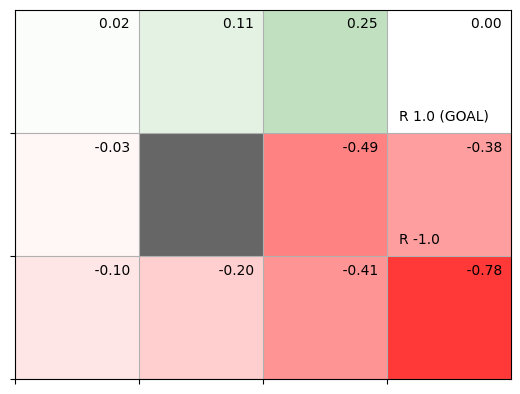

In [15]:
env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):  # 에피소드 1000번 수행
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)             # 행동 선택
        # print(state, action)
        next_state, reward, done = env.step(action)  # 행동 수행
        # print(next_state, reward, done)
        agent.add(state, action, reward)  # (상태, 행동, 보상) 저장
        
        if done:   # 목표에 도달 시
            agent.eval()  # 몬테카를로법으로 가치 함수 갱신
            break         # 다음 에피소드 시작

        state = next_state

# 모든 에피소드 종료

# [그림 5-12] 몬테카를로법으로 얻은 가치 함수
env.render_v(agent.V)

에피소드를 총 1000번 실행했습니다. 에피소드가 시작되면 환경과 에이전트를 초기화한 다음 while문 안에서 나머지 작업들을 처리합니다. 먼저 에이전트에게 행동하게 하고 그 결과로 얻은 
'상태, 행동, 보상'의 샘플 데이터를 기록합니다. 목표에 도달하면 그동안 얻은 샘플 데이터를 이용하여 몬테카를로법으로 가치함수를 갱신합니다. 그 다음 while문을 빠져나와 다음 에피소드를 시작합니다.  

그리고 1000번의 에피소드가 모두 끝나면 env.render_v(agent.V) 코드에서 가치함수를 시각화합니다.

<p align="center"><img src="./images/fig_05_12.png" width=700></p>

이번에는 **무작위 정책의 가치함수를 평가**했습니다. 에이전트의 시작 위치는 왼쪽 맨 아래의 한 곳으로 고정되어 있지만 무작위 정책이기 때문에 어떠한 위치든 경유할 수 있습니다. 그래서 모든 위치(상태)에서의 가치 함수를 평가할 수 있습니다.

<p align="center"><img src="./images/fig_05_13.png" width=700></p>

몬테카를로법을 이용한 왼쪽 결과와 동적 프로그래밍으로 얻은 오른쪽 결과의 차이가 거의 없음을 알 수 있습니다. 이처럼 몬테카를로법을 이용하면 환경 모델을 몰라도 정책 평가를 제대로 할 수 있습니다.

## 5.4 몬테카를로법으로 정책 제어하기

앞서 5.2절에서는 몬테카를로법으로 '정책 평가'를 수행했습니다. 정책 평가의 다음 단계는 **최적 정책을 찾는 '정책 제어'** 입니다. 정책 제어의 핵심은 평가와 개선을 번갈아 반복하는 것입니다.

### 5.4.1 평가와 개선

이제 몬테카를로법으로 정책을 제어하는 에이전트를 구현하겠습니다. 클래스 이름은 McAgent입니다.

In [16]:
class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0) # V가 아닌 Q를 사용
        self.cnts = defaultdict(lambda: 0)
        self.memory = []
    
    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()


앞 절에서 구현한 RandomAgent 클래스와 거의 같습니다. 유일한 차이는 self.V에서 self.Q로 이름을 바꾼 부분입니다.

이어서 핵심인 정책 제어를 구현합니다.

In [17]:
def greedy_probs(Q, state, action_size = 4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    action_probs = {action: 0.0 for action in range(action_size)}
    # 이 시점에서 action_probs는 {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}이 됨
    action_probs[max_action] = 1 # 1
    return action_probs # 탐욕 행동을 취하는 확률 분포 반환

class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0) # V가 아닌 Q를 사용
        self.cnts = defaultdict(lambda: 0)
        self.memory = []
    
    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.cnts[key] += 1
            # [식 5.5]에 따라 self.Q 갱신
            self.Q[key] += (G - self.Q[key]) / self.cnts[key] # 2

            # state의 정책 탐욕화
            self.pi[state] = greedy_probs(self.Q, state)


먼저 greedy_probs()는 탐욕 행동을 취하도록 하는 확률 분포를 반환합니다. 즉 매개변수로 받은 state 상태에서 Q 함수의 값이 가장 큰 행동만들 취하게끔 확률 분포를 만들어줍니다. 예를 들어 주어진 상태에서 0번째 행동의 Q 함수 값이 가장 크다면 {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}을 반환합니다

updata() 메서드에서는 self.Q를 갱신합니다. 여기서 주의할 점은 self.Q의 키가 (state, action) 튜플이라는 점입니다. 그리고 [식5.5]에 따라 '증분 방식'으로 self.Q를 갱신하고, self.Q 갱신이 끝나면 state의 정책을 탐욕화합니다.

이상이 McAgent 클래스입니다. 그런데 사실 이 코드는 제대로 작동하지 못합니다. 개선할 점이 두 가지 있는데, 바로 다음 부분입니다.
- 코드의 1: 완전한 탐욕이 아닌 $\epsilon$-탐욕 정책을 변경
- 코드의 2: Q 갱신을 '고정값 a 방식'으로 수행

### 5.4.3 $\epsilon$-탐욕 정책으로 변경(첫 번째 개선 사항)

에이전트는 개선 단계에서 정책을 탐욕화합니다. 탐욕화의 결과로 해당 상태에서 취할 수 있는 행동이 단 하나로 고정됩니다.(만약 Q의 값이 같다면 여러 가지 행동을 취할 수도 있습니다) 예를 들어 정책을 탐욕화하여 [그림5-14]처럼 행동하게 되었다고 가정해봅시다.

<p align="center"><img src="./images/fig_05_14.png" width=400></p>

그림과 같이 탐욕 행동만을 수행하면 에이전트의 경로가 한 가지로 고정됩니다. 그러면 모든 상태와 행동 조합에 대한 수익 샘플데이터를 수집할 수 없겠죠. 이 문제를 해결하려면 에이전트가 '탐색'도 시도하도록 해야 합니다.

에이전트에게 탐색을 시키는 대표적인 방법이 $\epsilon$-탐욕 정책입니다. 기본적으로 Q 함수의 값이 가장 큰 행동을 선택하되, 무작위성을 '살짝' 첨가하여 낮은 확률로 아무 행동이나 선택하도록 하는 정책입니다. 이렇게 하면 각 상태에서 정해진 행동만 선택되는 문제를 방지할 수 있습니다. 그러면서도 대다수 경우에 탐욕 행동을 취하기 때문에 최적 정책에 가까운 결과를 얻을 수 있습니다.

이제 $\epsilon$-탐욕 버전의 greedy_probs() 함수를 구현해보겠습니다.

In [18]:
def greedy_probs(Q, state, epsilon=0.0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}
    # 이 시점에서 action_probs는 {0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

### 5.4.4 고정값 $\alpha$방식으로 수행(두 번째 개선 사항)

<p align="center"><img src="./images/fig_05_16_1.png" width=700></p>

<p align="center"><img src="./images/fig_05_15.png" width=400></p>

<p align="center"><img src="./images/fig_05_16.png" width=500></p>

수정 전 방식은 모든 샘플 데이터 ($G^{(1)},G^{(2)},\cdots,G^{(n)}$)에 가중치를 '균일'하게 주고 평균을 냅니다. '표본 평균'이죠. 표본 평균에서는 각 데이터에 대한 가중치가 모두 1/n입니다.

반면, 고정값 $\alpha$로 갱신하는 방식은 오른쪽 그림처럼 각 데이터에 대한 가중치가 '기하급수적'으로 커집니다. 이를 '지수 이동 평균'이라고 합니다. 지수 이동 평균은 최신 데이터일수록 가중치를 훨씬 크게 줍니다.

몬테카를로법을 이용한 정책 제어에는 지수 이동 평균이 적합합니다. '수익'이라는 샘플 데이터가 생성되는 확률 분포가 시간에 따라 달라지기 때문입니다. 더 정확히 말하며, 에피소드가 진행될수록 정책이 갱신되기 때문에 수익이 생성되는 확률 분포도 달라집니다. 샘플 데이터(수익)를 생성하는 확률분포가 일정하지 않은 경우에는 지수 이동 평균이 적합합니다.

### 5.4.5 몬테카를로법으로 정책 반복법 구현(개선 버전)

앞의 두 개선 사항을 반영하여 McAgent 클래스를 다음과 같이 수정했습니다.

In [19]:
class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1  # (첫 번째 개선) ε-탐욕 정책의 ε
        self.alpha = 0.1    # (두 번째 개선) Q 함수 갱신 시의 고정값 α
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        # self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            # self.cnts[key] += 1
            # self.Q[key] += (G - self.Q[key]) / self.cnts[key]
            self.Q[key] += (G - self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)


self.epsilon은 ε-탐욕 정책에서 무작위로 행동할 확률입니다. 지금처럼 0.1로 설정하면 10%의 확률로 무작위 행동을 선택하고, 90%의 확률로 탐욕 행동을 선택합니다. 코드 2에서 이 값을 greed_probs() 함수에 전달하여 ε-탐욕 정책에 따른 확률 분포를 만들도록 했습니다.

self.alpha는 Q 함수를 갱신할 때 사용하는 고정값입니다. 코드 1에서 고정값인 self.alpha로 Q 함수를 갱신합니다.

이제 새로운 McAgent 클래스를 GridWorld 클래스와 함께 사용해보겠습니다.

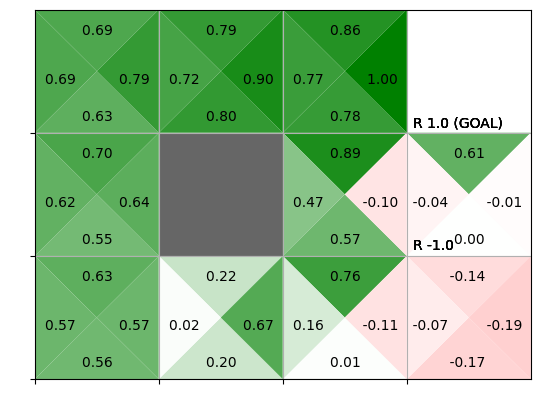

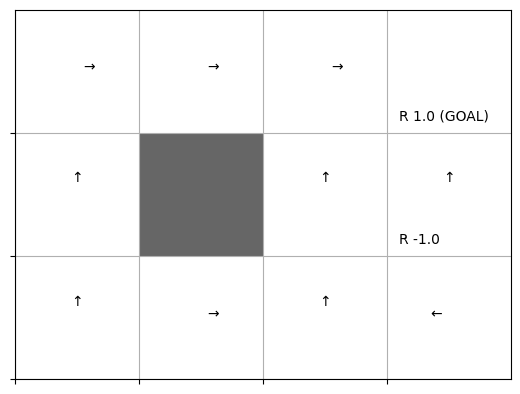

In [26]:
env = GridWorld()
agent = McAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

# [그림 5-17] 및 [그림 5-18]
env.render_q(agent.Q)

총 1만번의 에피소드로 학습하고, 마지막으로 env.render_q(agent.Q)로 Q 함수를 시각화했습니다.

각 상태에서 취할 수 있는 행동이 4가지이므로 [그림5-17]처럼 각 칸을 네개로 나누어 그렸습니다. 그림을 보면 마이너스 보상을 피하고 플러스 보상을 얻는 행동의 Q 함수가 커지는 것을 알 수 있습니다. 이 결과에서 탐욕 행동들만 뽑아내면 [그림5-18]처럼 됩니다.

이와 같이 Q 함수로부터 얻은 탐욕 정책으로도 최적 정책과 비슷한 결과를 얻을 수 있습니다. 실제로는 에이전트가 ε-탐욕 정책에 따라 어떤 상태에서는 낮은 확률로 무작위로 행동하기도 합니다. 하지만 대부분은 탐욕 행동을 선택하기 때문에 대체로 좋은 결과를 얻을 수 있습니다. 지금까지 몬테카를로법으로 정책 제어를 구현해보았습니다.

## 5.5 오프-정책과 중요도 샘플링

앞서 몬테카를로법에 ε-탐욕 정책을 결합하여 최적에 가까운 정책을 얻었습니다. 하지만 그 결과는 완벽한 최적 정책이 아닙니다. 우리는 (할 수만 있다면) Q 함수의 값이 가장 큰 행동만을 수행하도록 하고 싶습니다. 즉, '활용'만 하고 싶은 것입니다. 하지만 그러려면 '탐색'을 포기해야 합니다. 그래서 ε이라는 작은 확률로 탐색을 수행했습니다. 말하자면 ε-탐욕 정책은 일종의 타협인 셈입니다.

이번 절에서는 몬테카를로법을 이용해 완벽한 최적 정책을 학습하는 방법을 고민해보겠습니다. 이를 위한 준비 과정으로 먼저 온-정책과 오프-정책에 대해 알아 봅니다.

### 5.5.1 온-정책과 오프-정책

사람은 다른 사람의 행동을 관찰하여 자신의 능력을 개선할 힌트를 얻기도 합니다. 예를 들어 다른 테니스 선수가 스윙하는 모습을 보고 자신의 스윙자세를 고치기도 하죠. 

**오프-정책** off-policy  
강화학습 용어로는 '자신과 다른 환경에서 얻은 경험을 토대로 자신의 정책을 개선한다'고 표현할 수 있습니다. 이러한 접근 방식을 강화학습에서는 오프-정책 off-policy 이라고 합니다. 

**온-정책** on-policy  
반면 스스로 경험을 토대로 자신의 정책을 개선하는 방식은 온-정책 on-policy 이라고 합니다.

> NOTE : 역할 측면에서 보면 에이전트의 정책은 두 가지입니다. 하나는 평가와 개선의 대상으로서의 정책입니다. 즉, 정책에 대해 평가한 다음 개선합니다. 이러한 정책을 **대상 정책** target policy 이라고 합니다.  
다른 하나는 에이전트가 실제로 행동을 취할 때 활용하는 정책입니다. 이 정책에 따라 '상태, 행동, 보상'의 샘플 데이터가 생성됩니다. 이러한 정책을 **행동 정책** behaviour policy 이라고 합니다.

지금까지 이책에서는 '대상 정책'과 '행동 정책'을 구분하지 않았습니다. 즉, '평가와 개선의 대상인 대상 정책'과 '실제 행동을 선택하는 행동 정책'을 동일시 한 것입니다. 이처럼 두 정책이 같은 경우를 온-정책, 따로 떼어서 생각하는 경우를 오프-정책이라고 합니다. 오프-정책은 '대상 정책과 행동 정책이 떨어져 있다'라는 의미입니다.

이번 절의 주제는 **'오프-정책'** 입니다. 테니스 선수의 예처럼 다른 정책(행동 정책)에서 얻은 경험을 토대로 자신의 정책(대상 정책)을 평가하고 개선하는 것이죠. 오프-정책이라면 행동 정책에서는 '탐색'을, 대상 정책에서는 '활용'만을 할 수 있습니다. 다만, 행동 정책에서 얻은 샘플 데이터로부터 대상 정책과 관련된 기댓값을 계산하는 방법은 고민을 좀 해야 합니다. 이때 등장하는 것이 바로 중요도 샘플링 기법입니다.

### 5.5.2 중요도 샘플링

**중요도 샘플링** importance sampling 은 어떤 확률 분포의 기댓값을 다른 확률 분포에서 샘플링한 데이터를 사용하여 계산하는 기법입니다. $E_\pi[x]$라는 기댓값 계산을 예로 중요도 샘플링을 설명해보겠습니다. 여기선 x는 확률 변수이며 x의 확률은 $\pi(x)$로 표기합니다. 그래서 확률 분포의 기댓값은 다음 식으로 표현됩니다.

<p align="center"><img src="./images/eq_05_16_1.png" width=200></p>  

이 기댓값을 몬테카를로법으로 근사하려면 x를 확률 분포 $\pi$에서 샘플링하여 평균을 내면 됩니다.

<p align="center"><img src="./images/eq_05_16_2.png" width=300></p>

이 수식에서 $x^{(i)}$ ~ $\pi$ 표기는 확률 분포 $\pi$에서 i번째 데이터 $x^{(i)}$가 샘플링되었음을 나타냅니다.

이제 본론으로 들어갑시다. 지금 우리는 x가 다른 확률 분포에서 샘플링된 경우의 문제를 풀고자 합니다. 예를 들어 x가 ($\pi$가 아닌) b라는 확률 분포에서 샘플링되었다고 가정해봅시다. 이 경우에 기댓값 $E_\pi[x]$는 어떻게 근사할 수 있을까요? 해경의 열쇠는 다음과 같은 식 변형에 있습니다.

<p align="center"><img src="./images/eq_05_16.png" width=700></p>

여기서 핵심을 두 번째 줄에서 $\frac{b(x)}{b(x)}$를 끼워넣는 부분입니다. $\frac{b(x)}{b(x)}$는 항상 1이므로 등식이 성립합니다. 그리고 [식5.6]과 같이 $\sum \dots b(x)$ 형태로 바꾸면 확률 분포 $b(x)$에서의 기댓값으로 간주할 수 있습니다. 실제로 [식5.6]을 한 번 더 변형하면 다음 식을 얻을 수 있습니다.

<p align="center"><img src="./images/eq_05_17.png" width=700></p>

이 수식에서 주목할 부분은 $E_b$입니다. 확률 분포 $\pi$에 대한 기댓값을 확률 분포 b에 대한 기대값으로 표현해낸 것입니다. 또한 각각의  x에 $\frac{\pi(x)}{b(x)}$가 곱해진다는 점도 중요합니다. 여기서 $\rho(x) = \frac{\pi(x)}{b(x)}$라고 하면, 각각의 x에는 '가중치'로서 $\rho(x)$가 곱해진다고 볼 수 있습니다.

[식5.7]에 근거하여 몬테카를로법을 수식으로 표현하면 다음과 같습니다.

<p align="center"><img src="./images/eq_05_17_1.png" width=500></p>

이제 다른 확률 분포 b에서 샘플링한 데이터를 이용하여 $E_\pi[x]$를 계산할 수 있습니다.

그럼 이어서 중요도 샘플링을 코드로 구현해봅시다. [그림5-19]의 확률 분포를 대상으로 중요도 샘플링을 수행하겠습니다. 

<p align="center"><img src="./images/fig_05_19.png" width=500></p>

지금 목표는 기댓값 $E_\pi[x]$를 구하는 것입니다. 먼저 확률 분포 $\pi$의 기댓값을 일반적인 몬테카를로법으로 구해보겠습니다.

In [21]:
import numpy as np

x = np.array([1, 2, 3])         # 확률 변수
pi = np.array([0.1, 0.1, 0.8])  # 확률 분포

# =========== 기댓값의 참값 계산 ==================
e = np.sum(x * pi)
print('참값(E_pi[x]):', e)

# =========== 몬테카를로법으로 계산 ==================
n = 100  # 샘플 개수
samples = []
for _ in range(n):
    s = np.random.choice(x, p=pi)  # pi를 이용한 샘플링
    samples.append(s)

mean = np.mean(samples)  # 샘플들의 평균
var = np.var(samples)    # 샘플들의 분산
print('몬테카를로법: {:.2f} (분산: {:.2f})'.format(np.mean(samples), np.var(samples)))

참값(E_pi[x]): 2.7
몬테카를로법: 2.78 (분산: 0.27)


먼저 기댓값을 정의식에 맞게 구합니다. 그 결과는 2.7입니다.

이어서 몬테카를로법을 이용하여 구합니다. 여기서는 확률 분포 $\pi$에서 데이터 100개만 샘플링하여 평균을 구했습니다. 그 결과는 2.78로 참값에 가깝게 나왔습니다. 분산은 0.27로 나왔네요. 이 값은 곧이어 중요도 샘플링의 겱과와 비교해볼 것입니다.

참고로 분산은 데이터가 얼마나 흩어져 있느가를 나타냅니다. 기댓값과 분산의 관계를 수식으로 표현하면 다음과 같습니다.

$$ Var[X] = E[(X-E[X])^2] $$

분산은 '데이터 X'와 'X의 평균인 $E[X]$'의 차이를 제곱한 값의 기댓값입니다. 직관적으로는 [그림5-20]과 같이 데이터의 '흩어진 정도'를 나타냅니다.

<p align="center"><img src="./images/fig_05_20.png" width=500></p>

이어서 중요도 샘플링을 이용하여 기댓값을 구해보겠습니다.

In [22]:
# =========== 중요도 샘플링으로 계산 ===========
b = np.array([1/3, 1/3, 1/3])
samples = []
for _ in range(n):
    idx = np.arange(len(b))         # b의 인덱스([0, 1, 2])
    i = np.random.choice(idx, p=b)  # b를 사용하여 샘플링
    s = x[i]
    rho = pi[i] / b[i]              # 가중치
    samples.append(rho * s)         # 샘플 데이터에 가중치를 곱해 저장
    
mean = np.mean(samples)
var = np.var(samples)
print('중요도 샘플링: {:.2f} (분산: {:.2f})'.format(np.mean(samples), np.var(samples)))

중요도 샘플링: 2.48 (분산: 9.56)


이번에는 확률 분포 b를 사용하여 샘플링합니다. 단, 샘플링하는 대상은 'b의 인덱스([0,1,2])'로 설정했습니다. 가중치 $\rho$를 계산할 때 샘플링한 인덱스를 사용하기 때문입니다. 

출력 결과를 보겠습니다. 평균은 2.88입니다. 참값인 2.7과는 비슷합니다. 한편 분산은 10.53으로, 데이터의 '흩어진 정도'가 몬테카를로법 때의 0.27보다 훨씬 큰 것을 알 수 있습니다.

### 5.5.3 분산을 작게 하기

분산이 작을수록 적은 샘플로도 정확하게 근사할 수 있습니다. 그래서 이제부터 중요도 샘플링에서 분산을 줄이는 방법을 알아보겠습니다. 먼저[그림5-21]을 보면서 중요도 샘플링을 쓰면 분산이 커지는 이유를 설명하겠습니다.

<p align="center"><img src="./images/fig_05_21.png" width=500></p>

[그림5-21]은 샘플 데이터로 3을 선택한 예를 보여줍니다. 이때 가중치 $\rho$는 2.4입니다. 즉, 3을 뽑았음에도 결과적으로 3 * 2.4 = 7.2 를 얻는다는 뜻입니다. 이유는 다음과 같습니다.
- 확률 분포 $\pi$를 기준으로 했을 때 3은 대표적인 값이기 때문에 (원래는) 3이 많이 샘플링되어야 한다.
- 하지만 확률 분포 b에서는 3이 특별히 많이 선택되지 않는다.
- 이 간극을 메우기 위해 3이 샘플링된 경우, 그 값이 커지도록 '가중치'를 곱하여 조정한다.

이처럼 확률 분포 $\pi$ 와 b의 차이를 고려하여 샘플링된 값에 가중치를 곱하여 조정하는 일 자체는 의미가 있습니다. 하지만 샘플링된 값은 3인데 7.2로 취급한다면 그리고 만약 지금이 첫 번째 샘플데이터라면, 현시점의 추정값은 7.2가 된다는 문제가 생깁니다. 참값이 2.7이니 너무 크게 벗어나는 셈입니다. 이처럼 실제 얻은 값에 부여하는 가중치 $\rho$의 보정 효과가 클수록 분산이 커집니다.

그렇다면 어떻게 해야 분산을 줄일 수 있을까요? 두 확률 분포(b와 $\pi$)를 가깝게 만들면 됩니다. 이렇게 하면 가중치 $\rho$의 값을 1에 가깝게 만들 수 있습니다.

실험을 해봅시다. 직전 코드에서 확률 분포 b의 값만 바꿔보겠습니다.

In [23]:
# =========== 중요도 샘플링으로 계산 ===========
b = np.array([0.2, 0.2, 0.6]) # b = np.array([1/3, 1/3, 1/3])
samples = []
for _ in range(n):
    idx = np.arange(len(b))         # b의 인덱스([0, 1, 2])
    i = np.random.choice(idx, p=b)  # b를 사용하여 샘플링
    s = x[i]
    rho = pi[i] / b[i]              # 가중치
    samples.append(rho * s)         # 샘플 데이터에 가중치를 곱해 저장
    
mean = np.mean(samples)
var = np.var(samples)
print('중요도 샘플링: {:.2f} (분산: {:.2f})'.format(np.mean(samples), np.var(samples)))

중요도 샘플링: 2.57 (분산: 2.63)


이와 같이 확률 분포 b를 [0.2, 0.2, 0.6]으로 변경하여 확률 분포 $\pi$에 가깝게 만들어봅니다. (pi = [0.1, 0.1, 0.8]). 결과는 평균이 2.78로 참값에 더 가까워졌습니다. 분산은 2.45이며 이전 결과보다 작아졌음을 알 수 있습니다.

이처럼 중요도 샘플링 시 두 확률 분포를 비슷하게 설정하면 분산을 줄일 수 있습니다. 단, 강화학습에서 핵심은 한쪽 정책(확률 분포)은 '탐색'에, 다른 쪽 정책은 '활용'에 이용하는 것입니다. 이 조건을 염두에 둔 상태에서 두 확률 분포를 최대한 가깝게 조정하면 분산을 줄일 수 있습니다.

이것이 바로 중요도 샘플링입니다. 중요도 샘플링을 이용하면 오프-정책을 구현할 수 있습니다. 즉, 행동 정책이라는 확률 분포에서 샘플링된 데이터를 토대로 대상 정책에 대한 기댓값을 계산할 수 있습니다.

## Appendix A 오프-정책 몬테카를로법

### A.1 오프-정책 몬테카를로법 이론

'온-정책'방식의 몬테카를로법이 무엇인지부터 다시 정리해보요. 이번 절의 목표는 다음 식으로 정의되는 Q함수를 몬테카를로법으로 근사하는 것입니다.

<p align="center"><img src="./images/fig_A_00_1.png" width=250></p>

$q_\pi(s,a)$는 상태 s, 행동 a에서 시작하여 이후 정책 $\pi$에 따라 행동했을 때 얻는 수익 G의 기댓값입니다. 몬테카를로법을 이용해 Q함수를 근사하려면 정책$\pi$에 따라 행동하고 거기서 얻은 수익의 평균을 구하면 됩니다. 예를 들어 수익 샘플 데이터 n개 얻었다면 다음과 같이 근사할 수 있습니다.

<p align="center"><img src="./images/fig_A_00_2.png" width=400></p>

이어서 '오프-정책' 몬테카를로법을 생각해봅시다. 중요도 샘플링을 이용하면 Q함수를 다음 식으로 표현할 수 있습니다. 

<p align="center"><img src="./images/eq_A_01.png" width=470000></p>

여기서 중요한 점은 다음 두 가지 입니다. 
- 정책 b를 따를 때의 기댓값으로 표현($E_b[...])
- 두 정책(확률분포)의 차이를 메우기 위해 '가중치' 추가

가중치 $\rho$는 '정책 $\pi$를 가정했을 때 수익 G를 얻을 확률'과 '정책 b를 가정했을 때 수익 G를 얻을 확률'의 비율입니다. 이제 [식A.1]을 다음과 같이 몬테카를로법으로 근사합니다.

<p align="center"><img src="./images/fig_A_00_3.png" width=400></p>

i번째 수익 $G^{(i)}$의 가중치를 $\rho^{(i)}$로 표기했습니다. 이 식과 같이 에이전트는 행동 정책 b에 따라 행동하고, 거기서 얻은 샘플 데이터들에 가중치 $\rho$를 부여한 평균을 구합니다.  

다음으로 가중치 $\rho$를 구하는 방법을 알아보겠습니다. 정책 b에 의해 다음과 같은 시계열 데이터를 얻는다고 해보죠

<p align="center"><img src="./images/fig_A_01.png" width=600></p>

[그림A-1]의 시계열 데이터를 trajectory(궤적)라고 합니다. 즉, trajectory는 다음 식으로 정의됩니다.

<p align="center"><img src="./images/fig_A_01_1.png" width=400></p>

그러면 가중치 $\rho$는 다음처럼 표현할 수 있습니다.

<p align="center"><img src="./images/fig_A_01_2.png" width=300></p>

여기서 $P_r$은 확률을 뜻합니다. 그래서 $P_r(trajectory|\pi)$는 정책이 $\pi$일 때 trajectory가 얻어질 확률을 뜻하고, $P_r(trajectory|b)$는 정책이 $b$일때 trajectory를 얻을 확률을 뜻합니다.

$P_r(trajectory|b)$는 마르코프 결정 과정을 고려하면 더 간단하게 표현할 수 있습니다. 마르코프 결정 과정에서는 환경의 다음 상태와 에이전트의 행동이 한 단계 이전의 상태(와 행동)에만 의존하여 결정됩니다. 그림으로 표현하면 다음과 같습니다.

<p align="center"><img src="./images/fig_A_02.png" width=500></p>

그림과 같이 상태 s와 행동 a가 주어지면, 환경의 상태 전이 확률 $p(s'|s,a)$에 의해 다음 상태가 결정됩니다. 그리고 상태 s가 주어지면 에이전트의 정책 $b(a|s)$에 의해 다음 행동 a가 결정됩니다. 따라서 $P_r(trajectory|b)$는 다음 식으로 표현됩니다.

<p align="center"><img src="./images/eq_A_02.png" width=700></p>

이 식은 정책이 b일 때 trajectory라는 샘플 데이터를 얻을 확률입니다. 이와 같은 원리로 정책 $\pi$에 대해서는 다음 식을 얻을 수 있습니다.

<p align="center"><img src="./images/eq_A_03.png" width=700></p>

가중치 $\rho$는 [식A.2]와 식[A.3]의 비율입니다. 그런데 환경의 상태 전이 확률 $p(s'|s,a)$가 두 식 모두 등장합니다. 각각이 분모와 분자로 쓰이니 상쇄시키면 $\rho$의 식을 다음처럼 표현할 수 있습니다.

<p align="center"><img src="./images/eq_A_04.png" width=700></p>

[식A.4]와 같이 가중치 $\rho$는 정책만의 비율로 구할 수 있습니다. 이상이 오프-정책 몬테카를로법입니다. 알고리즘의 절차를 정리하면 다음과 같습니다.  

1. 행동 정책 $b$로 샘플링한다(시계열 데이터의 trajectory를 얻는다).  
2. 얻은 trajectory에서 수익 G를 계산한다.  
3. [식A.4]에 따라 가중치 $\rho$를 계산한다.  
4. 1~3을 여러 번 반복하여 $\rho G$의 평균을 구한다

### A.2 오프-정책 몬테카를로법 구현

이제 구현으로 넘어가겠습니다. 먼저 가중치 $\rho$를 효율적으로 구현하는 방법을 알아보겠습니다. 방법은 5.2.3절에서 설명한 것과 같습니다.

<p align="center"><img src="./images/fig_A_03.png" width=600></p>

[그림A-3]은 상태와 행동의 쌍 $(S_t,A_t)$를 시작 위치로 삼았을 때의 결과입니다. 이때 중간에 등장하는 상태와 행동 쌍 데이터들도 각각을 시작 위치로 해서 얻은 샘플 데이터로 간주할 수 있습니다. 따라서 가중치 $\rho$를 구할 때 왼쪽부터 계산하기보다는, 오른쪽 끝(목표)에서 출발하여 왼쪽으로 갱신하는 편이 효율적입니다. 좀 더 구체적으로 알아보겠습니다.


먼저 $\rho$의 초깃값을 1로 설정합니다. 그려면 $Q_\pi(S_{T-1},A_{T-1})$의 가중치 $\rho$는 1이 됩니다. 다음으로 $Q_\pi(S_{T-2},A_{T-2})$의 가중치 $\rho$를 다음과 같이 갱신합니다.

<p align="center"><img src="./images/fig_A_03_1.png" width=300></p>

같은 방법으로 $Q_\pi(S_{T-3},A_{T-3})$의 가중치는 다음과 같이 갱신합니다.

<p align="center"><img src="./images/fig_A_03_2.png" width=300></p>

이처럼 목표에서 시작하여 역방향으로 가중치를 갱신하면 효율적으로 계산할 수 있습니다.

이어서 오프-정책 몬테카를로법으로 정책을 제어하는 에이전트를 코드로 구현하겠습니다.

In [24]:
class McOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.2
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)  # 1 행동 정책 초기화
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.b[state]  # 2 행동 정책에서 행동 추출
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        rho = 1

        for data in reversed(self.memory):
            state, action, reward = data
            key = (state, action)

            # 3 샘플 데이터로 Q 함수 갱신
            G = self.gamma * rho * G + reward
            self.Q[key] += (G - self.Q[key]) * self.alpha
            rho *= self.pi[state][action] / self.b[state][action]

            # 4 pi는 탐욕 정책, b는 e-탐욕 정책으로 갱신
            self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
            self.b[state] = greedy_probs(self.Q, state, self.epsilon)

이 코드는 5.4절에서 구현한 McAgent 클래스와 거의 같습니다. 따라서 다른 점을 중심으로 설명하겠습니다.  

먼저 1에서는 b라는 이름의 행동 정책을 무작위 행동으로 초기화 합니다. 이어서 2의 get_action() 메서드에서는 정책 b에 따라 결정한 행동을 가져옵니다.  

3에서는 중요도 샘플링의 가중치 rho를 사용하여 갱신하고 있습니다. 코드가 복잡해 보일 수 있지만 5.4의 McAgent 클래스와 비교해보면 달라진 부분은 다음과 같이 아주 적습니다.

<p align="center"><img src="./images/fig_A_03_3.png" width=700></p>

샘플 데이터로 얻은 수익은 가중치 rho로 보정해야 합니다. 따라서 이와 같이 수익 G의 갱신에 rho를 사용합니다.  

마지막으로 4에서 정책을 개선합니다. 행동 정책 b는 $\epsilon$-탐욕정책($\epsilon$=0.1)으로 갱신하고, 대상 정책 $\pi$는 $\epsilon$-탐욕 정책($\epsilon$=0)으로 갱신합니다. 대상 정책 $\pi$에서는 $\epsilon = 0$이므로 완전히 탐욕화 시켰습니다.

> NOTE_ 행동 정책은 '탐색'이 목적이므로 모든 행동을 균등하게 선택하는 정책(무작위 정책)도 괜찮습니다. 하지만 여기서는 수익의 분산을 줄이기 위해 행동 정책 b를 $\epsilon$-탐욕정책으로 갱신함으로써, 행동 정책 b를 대상 정책 pi의 확률 분포에 가깝게 만들면서 탐색을 수행할 수 있습니다. 두 확률 분포를 가깝게 만들면 분산이 작아진다는 사실은 5.5.3절에서 설명했습니다.

이제 McOffPolicyAgent 클래스를 사용하여 문제를 풀어봅시다. 결과는 다음과 같습니다.

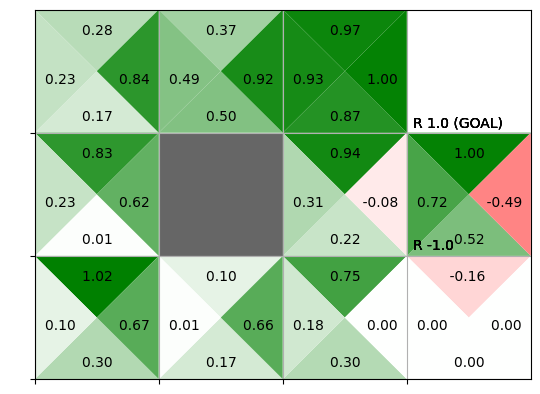

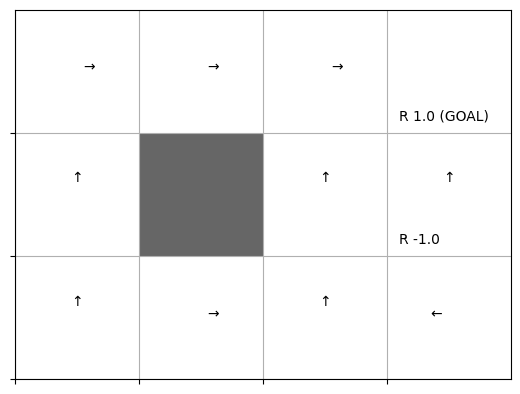

In [29]:
env = GridWorld()
agent = McOffPolicyAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)

<p align="center"><img src="./images/fig_A_04.png" width=700></p>

결과는 매번 달라지지만 대체로 좋은 결과를 얻을 수 있습니다. 참고로 [그림A-4]의 정책은 최적 정책과 일치합니다.

> CAUTION_ 이번에 살펴본 오프-정책 몬테카를로법이 잘 작동했습니다. 하지만 문제가 커지면 좋은 결과를 얻기가 어려워집니다. 샘플 데이터의 분산이 커지기 때문입니다. 그렇다면 분산이 커지는 이유는 무엇일까요? 문제가 커질수록 목표에 도달하기까지 더 많은 상태와 행동을 거쳐야 하기 때문입니다. 그만큼 중요도 샘플링에 의한 가중치 $\rho$의 분산이 커지는 것이죠. 이처럼 오프-정책 몬테카를로법은 정책 개선에 대량의 에피소드가 필요하고 계산에 시간이 오래 걸린다는 단점이 있습니다.

## 5.6 정리

강화학습에서는 에이전트가 주어진 환경에서 실제로 행동하고 거기서 얻은 경험을 바탕으로 더 나은 정책을 찾습니다. 환경과 에이전트의 이러한 상호작용이 강화학습의 특징입니다. 이번 장에서 배운 기술은 몬테카를로법입니다. 몬테카를로법을 이용하면 실제로 얻은 경험 데이터로부터 가치 함수를 근사적으로 구할 수 있습니다. 

몬테카를로법으로 Q 함수를 평가할 수 있다면, 이어서 Q 함수를 이용하여 정책을 개선할 수 있습니다. 이 평가와 개선을 번갈아 반복하면 더 나은 정책을 얻을 수 있죠. 다만 정책 개선 작업을 완전히 탐욕스럽게 하면 더 이상 '탐색'을 할 수 없게 됩니다 .그래서 이번 장에서는 완전한 탐욕 정책이 아닌 ε-탐욕 정책으로 갱신하여 활용과 탐색의 균형을 맞췄습니다. 강화 학습 문제에서는 활용과 탐색의 균형을 맞추면서 최선의 행동을 찾아야 합니다. 

또한 에이전트의 정책은 역할 측면에서 볼 때, 대상 정책과 행동 정책으로 나뉜다고 설명했습니다. 행동 정책에 따라 실제 행동을 선택하고 그렇게 경험을 쌓아 대상 정책을 갱신합니다. 대상 정책과 행동 정책이 같은 경우를 온-정책, 둘을 분리해서 생각하는 경우를 오프-정책이라고 합니다. 오프-정책에서는 행동 정책에 따라 행동하고 그 결과를 이용하여 대상 정책에 대한 기댓값을 계산해야 합니다. 이 계산을 가능하게 하는 수단이 중요도 샘플링입니다. 
